Clean notebook to plot Stokes parameters of NenuFAR dynamic spectra

In [1]:
import warnings
warnings.filterwarnings('ignore')

from nenupy.io import Spectra
from nenupy.io.tf import TFTask, TFPipeline
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astropy.units as u
from astropy.time import Time
from datetime import datetime

In [25]:
date     = '2025-03-25'
data_dir = '/databf/nenufar-tf/LT11'
obs_dir  = '20250325_091200_20250325_145000_SUN_TRACKING'

start_time = '2025-03-25T10:35:45'
end_time   = '2025-03-25T10:36:25'
figsize = [7,4]

year, month, day = date.split('-')
spectra_files = sorted(glob.glob(f'{data_dir}/{year}/{month}/{obs_dir}/*.spectra'))
low_freq_path  = [ file for file in spectra_files if file.endswith('_0.spectra') ][0]
high_freq_path = [ file for file in spectra_files if file.endswith('_1.spectra') ][0]

print(low_freq_path, high_freq_path, sep='\n')

/databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_0.spectra
/databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_1.spectra


2025-05-02 16:19:16 | INFO: Reading /databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_0.spectra...
2025-05-02 16:19:16 | INFO: 	/databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_0.spectra has been correctly parsed.
2025-05-02 16:19:16 | INFO: Checking for missing data (can take up to 1 min)...
2025-05-02 16:19:16 | INFO: 	There are 3/22914 blocks containing missing data and/or wrong time information.
2025-05-02 16:19:16 | INFO: Computing time-frequency axes...
2025-05-02 16:19:16 | INFO: Re-organize data into Jones matrices...
2025-05-02 16:19:16 | INFO: 	Convert data to Dask array
2025-05-02 16:19:16 | INFO: Data loaded.
2025-05-02 16:19:16 | INFO: Selecting times (between 2025-03-25T10:35:45.000 and 2025-03-25T10:36:25.000)...
2025-05-02 16:19:17 | INFO: 	1909 time samples selected.
2025-05-02 16:19:17 | INFO: Selecting frequencies (between 21.6796875 MHz and 59.1796875 MHz

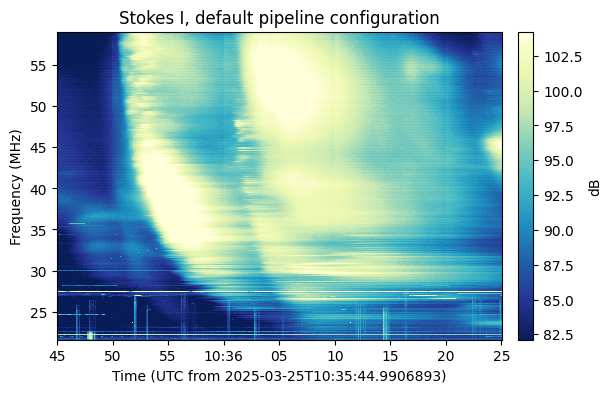

In [20]:
stokes_param = 'I'
low_data_i = Spectra(filename=low_freq_path)
low_data_i = low_data_i.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
low_data_i.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

In [43]:
# stokes_param = 'Q'
# low_data_q = Spectra(filename=low_freq_path)
# low_data_q = low_data_q.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
# low_data_q.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

In [42]:
# stokes_param = 'U'
# low_data_u = Spectra(filename=low_freq_path)
# low_data_u = low_data_u.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
# low_data_u.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

In [41]:
# stokes_param = 'V'
# low_data_v = Spectra(filename=low_freq_path)
# low_data_v = low_data_v.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
# low_data_v.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

In [44]:
# u_i = low_data_u.data/low_data_i.data
# u_i = np.squeeze(u_i)
# freqs = low_data_i.freq.to_value('MHz')
# times = np.array([datetime.utcfromtimestamp(t) for t in low_data_i.time.unix])

# fig = plt.figure(figsize=[7,4])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(times, freqs, u_i.T,
#                     vmin=-0.5, vmax=0.5,
#                     shading='auto', cmap='seismic')
# fig.colorbar(pc, ax=ax, label='degree of U/I')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

2025-05-02 16:50:23 | INFO: Reading /databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_1.spectra...
2025-05-02 16:50:23 | INFO: 	/databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_1.spectra has been correctly parsed.
2025-05-02 16:50:23 | INFO: Checking for missing data (can take up to 1 min)...
2025-05-02 16:50:23 | INFO: 	There are 2/15276 blocks containing missing data and/or wrong time information.
2025-05-02 16:50:23 | INFO: Computing time-frequency axes...
2025-05-02 16:50:23 | INFO: Re-organize data into Jones matrices...
2025-05-02 16:50:23 | INFO: 	Convert data to Dask array
2025-05-02 16:50:23 | INFO: Data loaded.
2025-05-02 16:50:23 | INFO: Selecting times (between 2025-03-25T10:35:45.000 and 2025-03-25T10:36:25.000)...
2025-05-02 16:50:23 | INFO: 	1909 time samples selected.
2025-05-02 16:50:23 | INFO: Selecting frequencies (between 59.1796875 MHz and 84.1796875 MHz

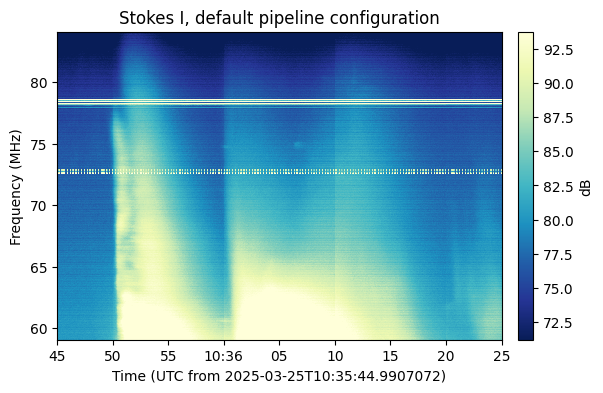

In [45]:
stokes_param = 'I'
high_data_i = Spectra(filename=high_freq_path)
high_data_i = high_data_i.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
high_data_i.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

In [46]:
low_times = np.array([datetime.utcfromtimestamp(t) for t in low_data_i.time.unix])
high_times = np.array([datetime.utcfromtimestamp(t) for t in high_data_i.time.unix])

In [50]:
low_times[0], low_times[-1], np.diff(low_times)

(datetime.datetime(2025, 3, 25, 10, 35, 44, 990689),
 datetime.datetime(2025, 3, 25, 10, 36, 25, 4349),
 array([datetime.timedelta(microseconds=20972),
        datetime.timedelta(microseconds=20971),
        datetime.timedelta(microseconds=20972), ...,
        datetime.timedelta(microseconds=20971),
        datetime.timedelta(microseconds=20972),
        datetime.timedelta(microseconds=20971)], dtype=object))

In [51]:
high_times[0], high_times[-1], 

(datetime.datetime(2025, 3, 25, 10, 35, 44, 990707),
 datetime.datetime(2025, 3, 25, 10, 36, 25, 4370),
 array([datetime.timedelta(microseconds=20972),
        datetime.timedelta(microseconds=20971),
        datetime.timedelta(microseconds=20972), ...,
        datetime.timedelta(microseconds=20972),
        datetime.timedelta(microseconds=20971),
        datetime.timedelta(microseconds=20972)], dtype=object))

In [60]:
print(f'Difference in start times: {(high_times[0] - low_times[0]).total_seconds()*1e6} us')
print(f'Difference in end times: {(high_times[-1] - low_times[-1]).total_seconds()*1e6} us')

Difference in start times: 18.0 us
Difference in end times: 21.0 us


In [83]:
low_dt_us = [ t.total_seconds()*1e6 for t in np.diff(low_times) ]
high_dt_us = [ t.total_seconds()*1e6 for t in np.diff(high_times) ]

In [84]:
low_dt_ms = [ t.total_seconds()*1e3 for t in np.diff(low_times) ]
high_dt_ms = [ t.total_seconds()*1e3 for t in np.diff(high_times) ]

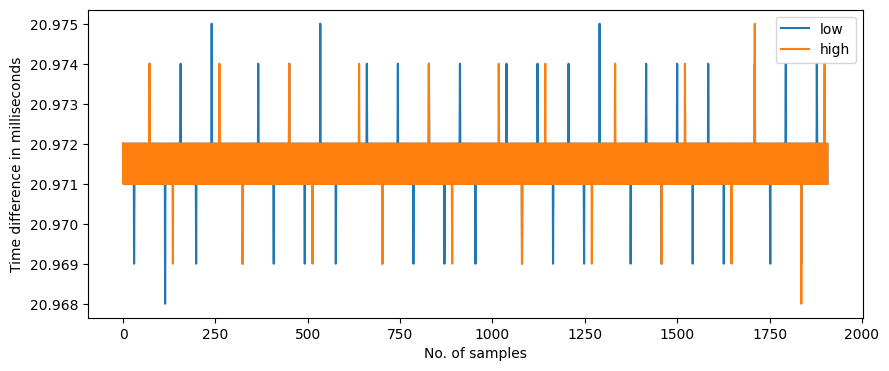

In [92]:
plt.figure(figsize=[10,4])
plt.plot(low_dt_ms, label='low')
plt.plot(high_dt_ms, label='high')
plt.xlabel('No. of samples')
plt.ylabel('Time difference in milliseconds')
plt.legend(loc='best')
plt.show()

In [109]:
combined_data  = np.concatenate((low_data_i.data, high_data_i.data), axis=1)
combined_data  = np.squeeze(combined_data)
combined_data  = 10 * np.log10(combined_data) # Convert the amplitude in decibels
combined_freqs = np.concatenate((low_data_i.freq.to_value('MHz'), high_data_i.freq.to_value('MHz')))

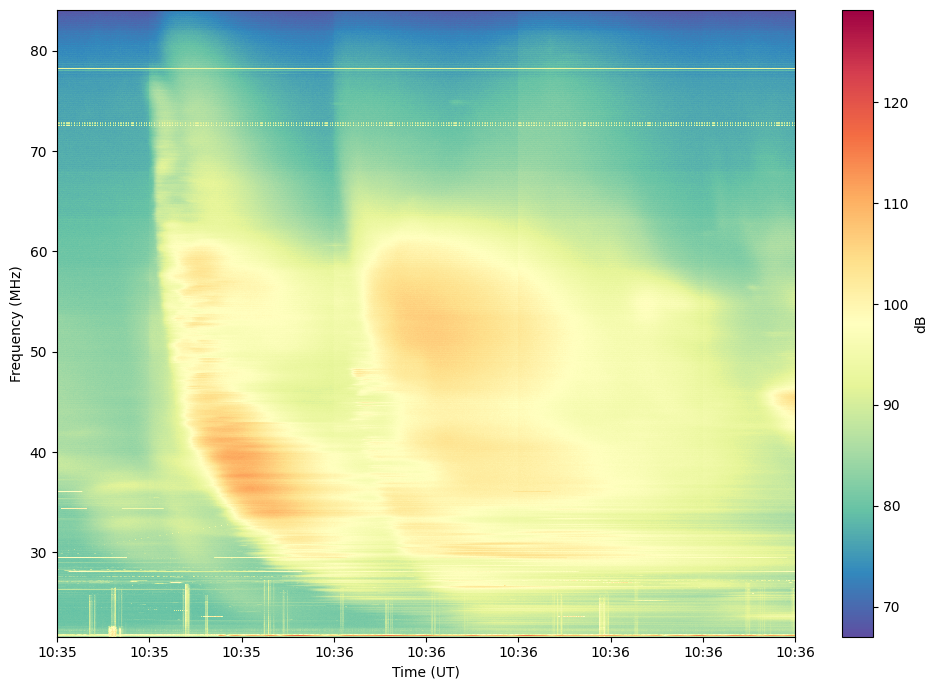

In [110]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(low_times, combined_freqs, combined_data.T,
                    # vmin=7, vmax=11,
                    shading='auto', cmap='Spectral_r') # Spectral_r, YlGnBu_r
fig.colorbar(pc, ax=ax, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()